In [ ]:
!pip install ginza
!pip install ja-ginza

In [ ]:
from google.colab import drive
import pandas as pd
import json
from datetime import datetime
import numpy as np
import os
from collections import Counter
from pathlib import Path

In [ ]:
!pip install torch

In [ ]:
!pip install Cython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ja_core_news_smをダウンロード
!python -m spacy download ja_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 64.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import ginza
import spacy
# GINZAを読み込む（モデルの選択）
nlp = spacy.load("ja_ginza")
#nlp = spacy.load('ja_core_news_sm')

# JSONファイルの格納先
folder_path = '/content/drive/MyDrive/対照群コーパス/対照群コーパス'

#形態素解析のモードAが細分割、Cが広分割
ginza.set_split_mode(nlp, 'C')

In [ ]:
#jsonファイルのやつ
# 結果を格納するリスト
results = []

# JSONファイルを1から14000まで読み込み
for i in range(1, 14000):
    file_path = os.path.join(folder_path, f'{i:05d}.json')

    # ファイルが存在するか確認し、存在しない場合はスキップ
    if not os.path.isfile(file_path):
        print(f"ファイル {file_path} が見つかりません。スキップします。")
        continue

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    utterances = [u['text'] for u in data['utterances']]
    timestamps_str = [u['timestamp'] for u in data['utterances']]

    # ISOフォーマット文字列からdatetimeオブジェクトに変換し、NaTを検出
    timestamps = []
    all_valid = True
    for ts in timestamps_str:
        try:
            ts_dt = datetime.fromisoformat(ts)
            timestamps.append(ts_dt)
        except ValueError:
            timestamps.append(pd.NaT)
            all_valid = False  # 少なくとも1つが無効であればフラグを立てる

    # タイムスタンプがNaTを含む場合はスキップ
    if not all_valid:
        print(f"ファイル {file_path} に無効なタイムスタンプが含まれています。スキップします。")
        continue

    # 各発話を解析し、結果を保存する
    doc = nlp(" ".join(utterances))

    # 各品詞のカウントと割合計算
    pos_counts = Counter([token.pos_ for token in doc])
    total_tokens = sum(pos_counts.values())
    pos_ratios = {pos: count / total_tokens for pos, count in pos_counts.items()}

    # 一般名詞割合
    noun_counts = sum(1 for token in doc if token.pos_ == "NOUN")
    common_noun_ratio = noun_counts / total_tokens

    # 固有名詞割合
    proper_noun_counts = sum(1 for token in doc if token.pos_ == "PROPN")
    proper_noun_ratio = proper_noun_counts / total_tokens

    # 最大係り受け距離と平均係り受け距離
    dependency_distances = [abs(token.head.i - token.i) for token in doc]
    max_dependency_distance = max(dependency_distances)
    average_dependency_distance = np.mean(dependency_distances)

    # TTR（Type Token Ratio）
    unique_tokens = len(set([token.text for token in doc]))
    ttr = unique_tokens / total_tokens

    # 異なり名詞割合
    unique_nouns = len(set([token.text for token in doc if token.pos_ == "NOUN"]))
    unique_noun_ratio = unique_nouns / total_tokens

    # 代名詞割合
    pronoun_counts = sum(1 for token in doc if token.pos_ == "PRON")
    pronoun_ratio = pronoun_counts / total_tokens

    # フィラー割合
    filler_counts = sum(1 for token in doc if token.text in ["えー", "あー", "うーん", "えっと"])
    filler_ratio = filler_counts / total_tokens

    # 反応時間計算
    reaction_times = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
    average_reaction_time = np.mean(reaction_times)
    variance_reaction_time = np.var(reaction_times)

    # 結果をリストに追加
    results.append({
        'File': f'{i:05d}.json',
        '一般名詞割合': common_noun_ratio,
        '固有名詞割合': proper_noun_ratio,
        '最大係り受け距離': max_dependency_distance,
        #'平均係り受け距離': average_dependency_distance,
        'TTR（Type Token Ratio)': ttr,
        '異なり名詞割合': unique_noun_ratio,
        '代名詞割合': pronoun_ratio,
        'フィラー割合': filler_ratio,
        '平均反応時間': average_reaction_time,
        '反応時間の分散': variance_reaction_time
    })

# 結果をDataFrameに変換
df = pd.DataFrame(results)

# 結果をCSVファイルに保存
csv_file_path = "results.csv"  # 保存するCSVファイルのパスを設定
df.to_csv(csv_file_path, index=False)

# データを表示
print(df.head())  # 最初の5行を表示

ファイル /content/drive/MyDrive/コーパス/dialogues/00054.json が見つかりません。スキップします。
ファイル /content/drive/MyDrive/コーパス/dialogues/00070.json が見つかりません。スキップします。
ファイル /content/drive/MyDrive/コーパス/dialogues/00071.json が見つかりません。スキップします。
ファイル /content/drive/MyDrive/コーパス/dialogues/00073.json が見つかりません。スキップします。
         File    一般名詞割合    固有名詞割合  最大係り受け距離  TTR（Type Token Ratio)   異なり名詞割合  \
0  00001.json  0.132492  0.015773        12               0.365931  0.094637   
1  00002.json  0.168766  0.002519        12               0.360202  0.103275   
2  00003.json  0.112245  0.007653        18               0.349490  0.081633   
3  00004.json  0.125326  0.031332        18               0.360313  0.086162   
4  00005.json  0.138958  0.009926        11               0.382134  0.101737   

      代名詞割合    フィラー割合     平均反応時間    反応時間の分散  
0  0.025237  0.000000  14.938172  26.672535  
1  0.017632  0.000000  17.536966  32.069827  
2  0.022959  0.002551  16.862069  60.739596  
3  0.023499  0.000000  17.060103  60.103633  
4

In [ ]:
import ginza
import spacy
# GINZAを読み込む（モデルの選択）
nlp = spacy.load("ja_ginza")
#nlp = spacy.load('ja_core_news_sm')

#形態素解析のモードAが細分割、Cが広分割
ginza.set_split_mode(nlp, 'C')

In [ ]:
#テキストファイルをやるやつ


# 結果を格納するリスト
results = []

# フォルダ内のすべてのテキストファイルを読み込む
folder_path = '/content/drive/MyDrive/対象群コーパス/仕分け済みコーパス'  # フォルダのパスを指定

# os.walkでフォルダ内のファイルを再帰的に検索
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        if file_name.endswith(".txt"):  # テキストファイルのみを対象とする
            file_path = os.path.join(root, file_name)

            # ファイルが存在するか確認
            if not os.path.isfile(file_path):
                print(f"ファイル {file_path} が見つかりません。スキップします。")
                continue

            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                # テキストが空でないことを確認
                if text.strip() == "":
                    print(f"ファイル {file_path} は空です。スキップします。")
                    continue

                print(f"ファイル {file_path} の内容:\n{text[:100]}...")  # 最初の100文字だけ表示

            # ファイルの内容を解析
            doc = nlp(text)
            print(f"解析結果: {doc[:10]}...")  # 最初の10トークンだけ表示

            # 各品詞のカウントと割合計算
            pos_counts = Counter([token.pos_ for token in doc])
            total_tokens = sum(pos_counts.values())
            if total_tokens == 0:
                print(f"ファイル {file_path} は有効なトークンがありません。スキップします。")
                continue

            pos_ratios = {pos: count / total_tokens for pos, count in pos_counts.items()}

            # 一般名詞割合
            noun_counts = sum(1 for token in doc if token.pos_ == "NOUN")
            common_noun_ratio = noun_counts / total_tokens

            # 固有名詞割合
            proper_noun_counts = sum(1 for token in doc if token.pos_ == "PROPN")
            proper_noun_ratio = proper_noun_counts / total_tokens

            # 最大係り受け距離と平均係り受け距離
            dependency_distances = [abs(token.head.i - token.i) for token in doc]
            max_dependency_distance = max(dependency_distances)
            average_dependency_distance = np.mean(dependency_distances)

            # TTR（Type Token Ratio）
            unique_tokens = len(set([token.text for token in doc]))
            ttr = unique_tokens / total_tokens

            # 異なり名詞割合
            unique_nouns = len(set([token.text for token in doc if token.pos_ == "NOUN"]))
            unique_noun_ratio = unique_nouns / total_tokens

            # 代名詞割合
            pronoun_counts = sum(1 for token in doc if token.pos_ == "PRON")
            pronoun_ratio = pronoun_counts / total_tokens

            # フィラー割合
            filler_counts = sum(1 for token in doc if token.text in ["えー", "あー", "うーん", "えっと"])
            filler_ratio = filler_counts / total_tokens

            # 結果をリストに追加
            results.append({
                'File': file_name,
                '一般名詞割合': common_noun_ratio,
                '固有名詞割合': proper_noun_ratio,
                '最大係り受け距離': max_dependency_distance,
                #'平均係り受け距離': average_dependency_distance,
                'TTR（Type Token Ratio)': ttr,
                '異なり名詞割合': unique_noun_ratio,
                '代名詞割合': pronoun_ratio,
                'フィラー割合': filler_ratio,
            })

# 結果をDataFrameに変換
df = pd.DataFrame(results)

# 結果をCSVファイルに保存
csv_file_path = "txt_results.csv"  # 保存するCSVファイルのパスを設定
df.to_csv(csv_file_path, index=False)

# データを表示
print(df.head())  # 最初の5行を表示

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# CSVファイルを読み込んでDataFrameとして表示
csv_file_path = "/content/txt_results.csv"  # 先ほど保存したCSVファイルのパスを指定
df_loaded = pd.read_csv(csv_file_path)
print(df_loaded.head())  # 最初の5行を表示

# 特徴量とラベルの設定
#X = df_loaded[['一般名詞割合', '固有名詞割合', '最大係り受け距離',
 #              'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
  #             'フィラー割合', '平均反応時間', '反応時間の分散']].values
#X = df_loaded[['平均反応時間']].values
# 特徴量とラベルの設定
X = df_loaded[['一般名詞割合', '固有名詞割合', '最大係り受け距離',
               'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
               'フィラー割合']].values

# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-Class SVMのモデルを作成し、学習
model = OneClassSVM(gamma='auto', nu=0.1)
model.fit(X_scaled)

# モデルを保存
model_file_path = "Newtxt_01_svm_model.pkl"
joblib.dump(model, model_file_path)
print(f"Model saved to {model_file_path}")

                 File    一般名詞割合    固有名詞割合  最大係り受け距離  TTR（Type Token Ratio)  \
0  S45_01_02_EP1b.txt  0.241379  0.000000         5               0.620690   
1  S45_01_05_EP4a.txt  0.154255  0.047872        17               0.430851   
2  S45_01_04_EP3a.txt  0.130682  0.045455        18               0.448864   
3  S45_01_03_EP2a.txt  0.143564  0.039604        22               0.445545   
4    S45_03_01_AM.txt  0.143959  0.035990        21               0.293059   

    異なり名詞割合     代名詞割合    フィラー割合  
0  0.241379  0.000000  0.103448  
1  0.090426  0.010638  0.058511  
2  0.090909  0.017045  0.073864  
3  0.118812  0.014851  0.079208  
4  0.082262  0.017995  0.061697  
Model saved to Newtxt_01_svm_model.pkl


In [ ]:
# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# スケーラーを保存
joblib.dump(scaler, 'Newtxt_01_scaler.pkl')


['Newtxt_01_scaler.pkl']

In [ ]:
import ginza
import spacy
import json
from datetime import datetime
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from collections import Counter

# GINZAを読み込む
nlp = spacy.load("ja_ginza")

# 学習済みモデルを読み込む
model_file_path = "svm_model.pkl"
loaded_model = joblib.load(model_file_path)

# 特徴量のスケーラーを読み込む
scaler_file_path = "scaler.pkl"
scaler = joblib.load(scaler_file_path)

# JSONファイルのパス
json_file_path = "/content/2024-07-30T14_20_27.887319.json"  # ここに新しいJSONファイルのパスを指定

# JSONデータの読み込み
with open(json_file_path, "r", encoding='utf-8') as f:
    data = json.load(f)

utterances = [u['text'] for u in data['utterances']]
timestamps_str = [u['timestamp'] for u in data['utterances']]

# ISOフォーマット文字列からdatetimeオブジェクトに変換
timestamps = []
for ts in timestamps_str:
    try:
        ts_dt = datetime.fromisoformat(ts)
        timestamps.append(ts_dt)
    except ValueError:
        timestamps.append(None)

# タイムスタンプに無効な値が含まれている場合は処理を中止
if None in timestamps:
    print("無効なタイムスタンプが含まれています。処理を中止します。")
    exit()

# 各発話を解析し、結果を計算する
doc = nlp(" ".join(utterances))

# 各品詞のカウントと割合計算
pos_counts = Counter([token.pos_ for token in doc])
total_tokens = sum(pos_counts.values())

# 一般名詞割合
noun_counts = sum(1 for token in doc if token.pos_ == "NOUN")
common_noun_ratio = noun_counts / total_tokens

# 固有名詞割合
proper_noun_counts = sum(1 for token in doc if token.pos_ == "PROPN")
proper_noun_ratio = proper_noun_counts / total_tokens

# 最大係り受け距離
dependency_distances = [abs(token.head.i - token.i) for token in doc]
max_dependency_distance = max(dependency_distances)

# TTR（Type Token Ratio）
unique_tokens = len(set([token.text for token in doc]))
ttr = unique_tokens / total_tokens

# 異なり名詞割合
unique_nouns = len(set([token.text for token in doc if token.pos_ == "NOUN"]))
unique_noun_ratio = unique_nouns / total_tokens

# 代名詞割合
pronoun_counts = sum(1 for token in doc if token.pos_ == "PRON")
pronoun_ratio = pronoun_counts / total_tokens

# フィラー割合
filler_counts = sum(1 for token in doc if token.text in ["えー", "あー", "うーん", "えっと"])
filler_ratio = filler_counts / total_tokens

# 反応時間計算
reaction_times = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
average_reaction_time = np.mean(reaction_times)
variance_reaction_time = np.var(reaction_times)

# 特徴量をリストにまとめる
features = np.array([[common_noun_ratio, proper_noun_ratio, max_dependency_distance,
                      ttr, unique_noun_ratio, pronoun_ratio,
                      filler_ratio, average_reaction_time, variance_reaction_time]])

#features = np.array([[ average_reaction_time]])

# 特徴量のスケーリング
features_scaled = scaler.transform(features)

# モデルを使って予測
prediction = loaded_model.predict(features_scaled)

# 異常かどうかを表示
if prediction[0] == -1:
    print("このデータは異常です。")
else:
    print("このデータは正常です。")


このデータは正常です。


Model loaded successfully
正常データの数 (loaded model): 918
異常データの数 (loaded model): 42
                     特徴量       寄与度
3  TTR（Type Token Ratio)  0.158596
4                異なり名詞割合  0.147589
0                 一般名詞割合  0.108815
2               最大係り受け距離  0.040955
1                 固有名詞割合 -0.009910
5                  代名詞割合 -0.024223
6                 フィラー割合 -0.028317


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30064 (\N{CJK UNIFIED IDEOGRAPH-7570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python

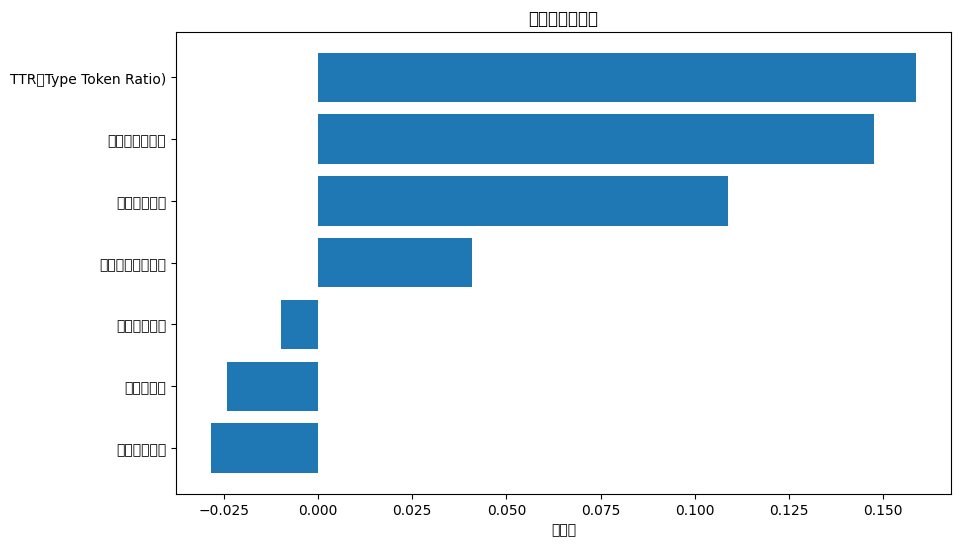

In [ ]:
#全体の異常数
# モデルを読み込む
loaded_model = joblib.load(model_file_path)
print("Model loaded successfully")

# データの予測
loaded_predictions = loaded_model.predict(X_scaled)

# 異常と正常の数をカウント
loaded_normal_count = np.sum(loaded_predictions == 1)
loaded_anomaly_count = np.sum(loaded_predictions == -1)

print(f'正常データの数 (loaded model): {loaded_normal_count}')
print(f'異常データの数 (loaded model): {loaded_anomaly_count}')

# 特徴量ごとに寄与度を評価するための関数
def evaluate_feature_importance(X_scaled, model):
    base_distances = pairwise_distances(X_scaled, X_scaled[model.predict(X_scaled) == 1], metric='euclidean').min(axis=1)

    importances = []
    for i in range(X_scaled.shape[1]):
        X_temp = X_scaled.copy()
        X_temp[:, i] = 0  # 特徴量iをゼロにする
        temp_distances = pairwise_distances(X_temp, X_temp[model.predict(X_temp) == 1], metric='euclidean').min(axis=1)
        importances.append(np.mean(temp_distances - base_distances))

    return importances

# 特徴量の寄与度を評価
importances = evaluate_feature_importance(X_scaled, loaded_model)

# 結果を表示
#feature_names = ['一般名詞割合', '固有名詞割合', '最大係り受け距離',
 #                'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
  #               'フィラー割合', '平均反応時間', '反応時間の分散']
# 結果を表示
feature_names = ['一般名詞割合', '固有名詞割合', '最大係り受け距離',
                 'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
                 'フィラー割合']

importance_df = pd.DataFrame({
    '特徴量': feature_names,
    '寄与度': importances
}).sort_values(by='寄与度', ascending=False)

print(importance_df)

# 寄与度を可視化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['特徴量'], importance_df['寄与度'])
plt.xlabel('寄与度')
plt.title('特徴量の寄与度')
plt.gca().invert_yaxis()
plt.show()

各品詞割合:
  VERB: 11.83%
  AUX: 9.74%
  INTJ: 2.09%
  PUNCT: 14.43%
  ADJ: 4.70%
  NOUN: 13.91%
  ADP: 20.52%
  PRON: 4.35%
  PART: 6.78%
  CCONJ: 0.70%
  SCONJ: 7.13%
  SYM: 0.35%
  ADV: 2.96%
  PROPN: 0.52%
一般名詞割合: 13.91%
固有名詞割合: 0.52%
最大係り受け距離: 19
TTR（Type Token Ratio): 28.52%
異なり名詞割合: 6.43%
代名詞割合: 4.35%
フィラー割合: 2000.00%
平均反応時間: 1000.00 秒
反応時間の分散: 110.93 秒^2
[[1000]]
Model loaded successfully
正常データの数 (loaded model): 1
異常データの数 (loaded model): 0
      特徴量  寄与度
0  平均反応時間  0.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24540 (\N{CJK UNIFIED IDEOGRAPH-5FDC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

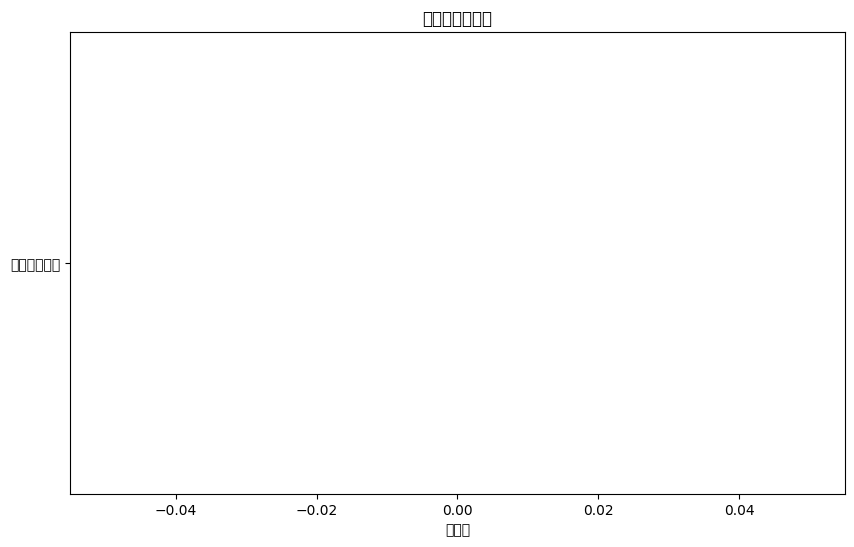

In [ ]:

import spacy
import json
from collections import Counter
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
import pandas as pd
import matplotlib.pyplot as plt
import joblib
# 結果を格納するリスト
results = []

# GINZAを読み込む
nlp = spacy.load("ja_ginza")

# JSONデータの読み込み
#json_data = '/content/2024-07-26T17_31_15.938892.json'

#data = json.loads(json_data)

json_file_path = '/content/2024-07-30T14_31_04.388619.json'

# JSONファイルの内容を読み込む
with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

utterances = [u['text'] for u in data['utterances']]
timestamps = [datetime.fromisoformat(u['timestamp']) for u in data['utterances']]

# 各発話を解析し、結果を保存する
doc = nlp(" ".join(utterances))

# 各品詞のカウントと割合計算
pos_counts = Counter([token.pos_ for token in doc])
total_tokens = sum(pos_counts.values())
pos_ratios = {pos: count / total_tokens for pos, count in pos_counts.items()}

# 一般名詞割合
noun_counts = sum(1 for token in doc if token.pos_ == "NOUN")
common_noun_ratio = noun_counts / total_tokens

# 固有名詞割合
proper_noun_counts = sum(1 for token in doc if token.pos_ == "PROPN")
proper_noun_ratio = proper_noun_counts / total_tokens

# 最大係り受け距離
max_dependency_distance = max(abs(token.head.i - token.i) for token in doc)

# TTR（Type Token Ratio）
unique_tokens = len(set([token.text for token in doc]))
ttr = unique_tokens / total_tokens

# 異なり名詞割合
unique_nouns = len(set([token.text for token in doc if token.pos_ == "NOUN"]))
unique_noun_ratio = unique_nouns / total_tokens

# 代名詞割合
pronoun_counts = sum(1 for token in doc if token.pos_ == "PRON")
pronoun_ratio = pronoun_counts / total_tokens

# フィラー割合
filler_counts = sum(1 for token in doc if token.text in ["えー", "あー", "うーん", "えっと"])
#filler_ratio = filler_counts / total_tokens
filler_ratio = 20

# 反応時間計算
reaction_times = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
#average_reaction_time = np.mean(reaction_times)
average_reaction_time = 1000
variance_reaction_time = np.var(reaction_times)

# 結果を表示
print("各品詞割合:")
for pos, ratio in pos_ratios.items():
    print(f"  {pos}: {ratio:.2%}")

print(f"一般名詞割合: {common_noun_ratio:.2%}")
print(f"固有名詞割合: {proper_noun_ratio:.2%}")
print(f"最大係り受け距離: {max_dependency_distance}")
print(f"TTR（Type Token Ratio): {ttr:.2%}")
print(f"異なり名詞割合: {unique_noun_ratio:.2%}")
print(f"代名詞割合: {pronoun_ratio:.2%}")
print(f"フィラー割合: {filler_ratio:.2%}")
print(f"平均反応時間: {average_reaction_time:.2f} 秒")
print(f"反応時間の分散: {variance_reaction_time:.2f} 秒^2")

results.append({
        'File': json_file_path,
        '一般名詞割合': common_noun_ratio,
        '固有名詞割合': proper_noun_ratio,
        '最大係り受け距離': max_dependency_distance,
        #'平均係り受け距離': average_dependency_distance,
        'TTR（Type Token Ratio)': ttr,
        '異なり名詞割合': unique_noun_ratio,
        '代名詞割合': pronoun_ratio,
        'フィラー割合': filler_ratio,
        '平均反応時間': average_reaction_time,
        '反応時間の分散': variance_reaction_time
    })

# 結果をDataFrameに変換
df = pd.DataFrame(results)


# 特徴量とラベルの設定
#X = df[['一般名詞割合', '固有名詞割合', '最大係り受け距離',
 #              'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
 #              'フィラー割合', '平均反応時間', '反応時間の分散']].values
X = df[['平均反応時間']].values
print(X)

# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#model_file_path = "/content/drive/MyDrive/コーパス/svm_model (1).pkl"
model_file_path = "/content/svm_model.pkl"

# モデルを読み込む
loaded_model = joblib.load(model_file_path)
print("Model loaded successfully")

# データの予測
loaded_predictions = loaded_model.predict(X_scaled)

# 異常と正常の数をカウント
loaded_normal_count = np.sum(loaded_predictions == 1)
loaded_anomaly_count = np.sum(loaded_predictions == -1)

print(f'正常データの数 (loaded model): {loaded_normal_count}')
print(f'異常データの数 (loaded model): {loaded_anomaly_count}')

# 特徴量ごとに寄与度を評価するための関数
def evaluate_feature_importance(X_scaled, model):
    base_distances = pairwise_distances(X_scaled, X_scaled[model.predict(X_scaled) == 1], metric='euclidean').min(axis=1)

    importances = []
    for i in range(X_scaled.shape[1]):
        X_temp = X_scaled.copy()
        X_temp[:, i] = 0  # 特徴量iをゼロにする
        temp_distances = pairwise_distances(X_temp, X_temp[model.predict(X_temp) == 1], metric='euclidean').min(axis=1)
        importances.append(np.mean(temp_distances - base_distances))

    return importances

# 特徴量の寄与度を評価
importances = evaluate_feature_importance(X_scaled, loaded_model)

# 結果を表示
#feature_names = ['一般名詞割合', '固有名詞割合', '最大係り受け距離',
 #                'TTR（Type Token Ratio)', '異なり名詞割合', '代名詞割合',
  #               'フィラー割合', '平均反応時間', '反応時間の分散']

feature_names = ['平均反応時間']

importance_df = pd.DataFrame({
    '特徴量': feature_names,
    '寄与度': importances
}).sort_values(by='寄与度', ascending=False)

print(importance_df)

# 寄与度を可視化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['特徴量'], importance_df['寄与度'])
plt.xlabel('寄与度')
plt.title('特徴量の寄与度')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import json

# JSONデータをPythonの辞書に変換
data = {
    "dialogue_id": 6,
    "interlocutors": [
        "USER",
        "AI"
    ],
    "utterances": [
        {
            "utterance_id": 0,
            "interlocutor_id": "USER",
            "text": "視聴いただきありがとうございます。良い一日を!",
            "timestamp": "2024-07-30T14:31:06.601701"
        },
        {
            "utterance_id": 1,
            "interlocutor_id": "AI",
            "text": "こんにちは！今日はどんなことを知りたいの？それとも、マインクラフトでお城を作る話をする？何でも聞いてね！",
            "timestamp": "2024-07-30T14:31:14.751192"
        },
        {
            "utterance_id": 2,
            "interlocutor_id": "USER",
            "text": "――それって何の話なのですか?",
            "timestamp": "2024-07-30T14:31:33.349047"
        },
        {
            "utterance_id": 3,
            "interlocutor_id": "AI",
            "text": "あ、ごめんね！さっきはちょっと興奮しちゃった。僕はマインクラフトでお城を作るのが好きなんだ。特にシンデレラ城を作りたいなって思ってるんだよ。でも、他にも色んなことに興味があるんだ。たとえば、空が青い理由とか、宇宙のこととか。君は何か興味があることある？",
            "timestamp": "2024-07-30T14:31:45.295432"
        },
        {
            "utterance_id": 4,
            "interlocutor_id": "USER",
            "text": "自分は何か興味を持っているのはないかもな。",
            "timestamp": "2024-07-30T14:32:19.673255"
        },
        {
            "utterance_id": 5,
            "interlocutor_id": "AI",
            "text": "そっか。でも、何か新しいことを見つけるのも楽しいよ！たとえば、マインクラフトを一緒にやってみるとか、面白い本を読んでみるとか。僕も最初は何に興味があるか分からなかったけど、色々試してみたら好きなことが見つかったんだ。何かやってみたいことがあったら教えてね！",
            "timestamp": "2024-07-30T14:32:32.341273"
        },
        {
            "utterance_id": 6,
            "interlocutor_id": "USER",
            "text": "あー、ありがとう。えっとー、あのー、えっとー、君は何が好きなのかな?",
            "timestamp": "2024-07-30T14:33:07.788558"
        },
        {
            "utterance_id": 7,
            "interlocutor_id": "AI",
            "text": "僕が好きなことはたくさんあるよ！マインクラフトでお城を作るのが一番好きだけど、他にも絵を描いたり、本を読んだりするのも好きだよ。あと、外で友達と遊ぶのも楽しいし、新しいことを学ぶのもワクワクするんだ。君は何か試してみたいこととかある？",
            "timestamp": "2024-07-30T14:33:19.761424"
        },
        {
            "utterance_id": 8,
            "interlocutor_id": "USER",
            "text": "へー、本好きなんだー。いいと思う。いいね。",
            "timestamp": "2024-07-30T14:33:51.904664"
        },
        {
            "utterance_id": 9,
            "interlocutor_id": "AI",
            "text": "ありがとう！本を読むと色んな世界に行けるし、たくさんのことを学べるから楽しいんだ。君も何か面白そうな本を見つけたら、ぜひ読んでみてね。きっと新しい発見があるよ！何か気になる本とかある？",
            "timestamp": "2024-07-30T14:34:04.094762"
        },
        {
            "utterance_id": 10,
            "interlocutor_id": "USER",
            "text": "気になる本か、えっと、なんだっけ、名前が思い出せないな。",
            "timestamp": "2024-07-30T14:34:37.262184"
        },
        {
            "utterance_id": 11,
            "interlocutor_id": "AI",
            "text": "大丈夫だよ！名前が思い出せなくても、どんな内容だったか教えてくれたら、一緒に探せるかもしれないよ。たとえば、冒険の話とか、魔法の話とか、どんな感じの本だったかな？",
            "timestamp": "2024-07-30T14:34:49.992755"
        },
        {
            "utterance_id": 12,
            "interlocutor_id": "USER",
            "text": "うーん、ほんとに覚えてないなー。ごめんね。",
            "timestamp": "2024-07-30T14:35:13.843448"
        },
        {
            "utterance_id": 13,
            "interlocutor_id": "AI",
            "text": "全然大丈夫だよ！無理しないでね。もし思い出したら教えてくれたらいいし、新しい本を探すのも楽しいかも。図書館とか本屋さんで色々見てみると、きっと面白そうな本が見つかるよ。何か他に興味があることがあったら、教えてね！",
            "timestamp": "2024-07-30T14:35:24.486651"
        },
        {
            "utterance_id": 14,
            "interlocutor_id": "USER",
            "text": "うん、ありがとう、またね",
            "timestamp": "2024-07-30T14:36:00.286759"
        },
        {
            "utterance_id": 15,
            "interlocutor_id": "AI",
            "text": "こちらこそ、ありがとう！またね、バイバイ！",
            "timestamp": "2024-07-30T14:36:09.935880"
        }
    ],
    "evaluations": [
        {
            "interlocutor_id": "USER",
            "informativeness": 5,
            "comprehension": 5,
            "familiarity": 5,
            "interest": 5,
            "proactiveness": 5,
            "satisfaction": 5
        },
        {
            "interlocutor_id": "AI",
            "informativeness": 5,
            "comprehension": 5,
            "familiarity": 5,
            "interest": 5,
            "proactiveness": 5,
            "satisfaction": 5
        }
    ]
}

# "AI"の発言を削除
data['utterances'] = [utterance for utterance in data['utterances'] if utterance['interlocutor_id'] != 'AI']

# 結果を出力
print(json.dumps(data, indent=2, ensure_ascii=False))


{
  "dialogue_id": 6,
  "interlocutors": [
    "USER",
    "AI"
  ],
  "utterances": [
    {
      "utterance_id": 0,
      "interlocutor_id": "USER",
      "text": "視聴いただきありがとうございます。良い一日を!",
      "timestamp": "2024-07-30T14:31:06.601701"
    },
    {
      "utterance_id": 2,
      "interlocutor_id": "USER",
      "text": "――それって何の話なのですか?",
      "timestamp": "2024-07-30T14:31:33.349047"
    },
    {
      "utterance_id": 4,
      "interlocutor_id": "USER",
      "text": "自分は何か興味を持っているのはないかもな。",
      "timestamp": "2024-07-30T14:32:19.673255"
    },
    {
      "utterance_id": 6,
      "interlocutor_id": "USER",
      "text": "あー、ありがとう。えっとー、あのー、えっとー、君は何が好きなのかな?",
      "timestamp": "2024-07-30T14:33:07.788558"
    },
    {
      "utterance_id": 8,
      "interlocutor_id": "USER",
      "text": "へー、本好きなんだー。いいと思う。いいね。",
      "timestamp": "2024-07-30T14:33:51.904664"
    },
    {
      "utterance_id": 10,
      "interlocutor_id": "USER",
      "text": "気になる本か、えっと、なんだっけ、名前が思い出せないな。",
   

In [ ]:
#フォルダごとに判断(全部一気に)
import os
import ginza
import spacy
from datetime import datetime
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from collections import Counter
seijou = 0
ijou = 0
count1 = 0
count2 = 0

# GINZAを読み込む
nlp = spacy.load("ja_ginza")

# 学習済みモデルを読み込む
model_file_path = "/content/Newtxt_01_svm_model.pkl"
loaded_model = joblib.load(model_file_path)

# 特徴量のスケーラーを読み込む
scaler_file_path = "/content/Newtxt_01_scaler.pkl"
scaler = joblib.load(scaler_file_path)

# 全部のやつ
#big_folder = "/content/drive/MyDrive/対象群コーパス/仕分け済みコーパス/非認知症/若者"
# 全部のやつ
big_folder = "/content/drive/MyDrive/対象群コーパス/仕分け済みコーパス/認知症"

# フォルダ内の全てのフォルダを取得
folder_list = os.listdir(big_folder)

# 各フォルダに対して処理を実行
for folder_name in folder_list:
    bigfolder_path = os.path.join(big_folder, folder_name)

    # フォルダのパス
    #folder_path = "/content/drive/MyDrive/対象群コーパス/対照群コーパス/S02"  # 処理対象のフォルダ

    # フォルダ内の全てのファイルを取得
    file_list = os.listdir(bigfolder_path)
    seijou = 0
    ijou = 0

    # 各ファイルに対して処理を実行
    for file_name in file_list:
        file_path = os.path.join(bigfolder_path, file_name)

        # テキストファイルの読み込み
        try:
            with open(file_path, "r", encoding='utf-8') as f:
                text = f.read()
                #print(text)
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
            continue

        # ファイルの内容を解析
        doc = nlp(text)
        #print(f"解析結果: {doc[:10]}...")  # 最初の10トークンだけ表示

        # 各品詞のカウントと割合計算
        pos_counts = Counter([token.pos_ for token in doc])
        total_tokens = sum(pos_counts.values())
        if total_tokens == 0:
            print(f"ファイル {file_path} は有効なトークンがありません。スキップします。")
            continue

        pos_ratios = {pos: count / total_tokens for pos, count in pos_counts.items()}

        # 一般名詞割合
        noun_counts = sum(1 for token in doc if token.pos_ == "NOUN")
        common_noun_ratio = noun_counts / total_tokens

        # 固有名詞割合
        proper_noun_counts = sum(1 for token in doc if token.pos_ == "PROPN")
        proper_noun_ratio = proper_noun_counts / total_tokens

        # 最大係り受け距離と平均係り受け距離
        dependency_distances = [abs(token.head.i - token.i) for token in doc]
        max_dependency_distance = max(dependency_distances)
        average_dependency_distance = np.mean(dependency_distances)

        # TTR（Type Token Ratio）
        unique_tokens = len(set([token.text for token in doc]))
        ttr = unique_tokens / total_tokens

        # 異なり名詞割合
        unique_nouns = len(set([token.text for token in doc if token.pos_ == "NOUN"]))
        unique_noun_ratio = unique_nouns / total_tokens

        # 代名詞割合
        pronoun_counts = sum(1 for token in doc if token.pos_ == "PRON")
        pronoun_ratio = pronoun_counts / total_tokens

        # フィラー割合
        filler_counts = sum(1 for token in doc if token.text in ["えー", "あー", "うーん", "えっと"])
        filler_ratio = filler_counts / total_tokens



        # 特徴量をリストにまとめる
        features = np.array([[common_noun_ratio, proper_noun_ratio, max_dependency_distance,
                              ttr, unique_noun_ratio, pronoun_ratio,filler_ratio]])

        # 特徴量のスケーリング
        features_scaled = scaler.transform(features)

        # モデルを使って予測
        prediction = loaded_model.predict(features_scaled)

        # 異常かどうかを表示
        if prediction[0] == -1:
            #print(f"File {file_name}: このデータは異常です。")
            ijou += 1
        elif prediction[0] == 1:
            #print(f"File {file_name}: このデータは正常です。")
            seijou += 1

    print(folder_name)

    if ijou >= 2:
      print("異常の可能性があります")
      count1 += 1
    else:
      print("正常")
      count2 += 1

print("異常の数："+str(count1))
print("正常の数："+str(count2))
print("判定確率：" + str(count2/(count1 + count2)))
#print('正常：'+ str(seijou))
#print('異常：'+ str(ijou))

S51
異常の可能性があります
S41
正常
S52
異常の可能性があります
S37
正常
S34
異常の可能性があります
S42
正常
S39
正常
S50
正常
S44
異常の可能性があります
S62
正常
S26
正常
S17
正常
S24
正常
S32
異常の可能性があります
S21
正常
異常の数：5
正常の数：10
判定確率：0.6666666666666666


In [ ]:
異常12+9=21
正常33+11=44
65+15=80
誤21+10=31